In [2]:
!pip install wtfml

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 608 kB/s eta 0:00:011
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=81aa57714dbb76822454b86cfc4fdff5e9391e6fb3040164ccc8ecc500ba6aa0
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [44]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=b4bc73a637400e626369ae082ad6b5dbf644e8809d78a38bbc33e3953bb57d75
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [45]:
from PIL import Image
import albumentations
from albumentations.core.composition import Compose
from albumentations.pytorch import ToTensorV2
from collections import defaultdict, deque


from efficientnet_pytorch import EfficientNet
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision.transforms import functional as F
from typing import Any, Dict, List, Union, Optional
import albumentations as A
import ast
import collections
import copy
import cv2
import datetime
import importlib
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

# import pretrainedmodels
import pytorch_lightning as pl
%matplotlib inline
import random
import seaborn as sns
import shutil
import tempfile
import time
import torch
import torch.distributed as dist
import torch.nn.functional as F
import torch.utils.data
import torchvision
from tqdm.notebook import tqdm
from sklearn import metrics, model_selection, preprocessing
sns.set_style('darkgrid')

In [5]:
#helper functions


def visualize(images, transform):
    """
    Plot images and their transformations
    """
    fig = plt.figure(figsize=(32, 16))
    
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        plt.imshow(im)
        
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i + 6, xticks=[], yticks=[])
        plt.imshow(transform(image=im)['image'])

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()


In [6]:
df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")

In [7]:
df

image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]

In [8]:
df.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [9]:
print(df.shape)

(21397, 2)


In [10]:
path = "../input/cassava-leaf-disease-classification/"

with open(f'{path}/label_num_to_disease_map.json', 'r') as f:
    name_mapping = json.load(f)
    
name_mapping = {int(k): v for k, v in name_mapping.items()}
name_mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

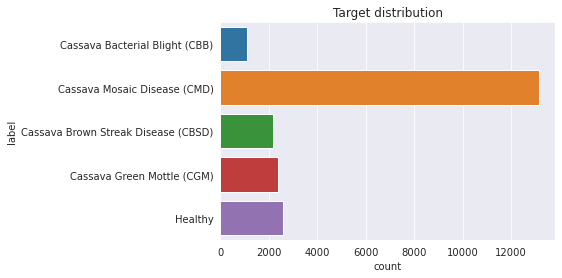

In [11]:
sns.countplot(y=df['label'].map(name_mapping), orient='v')
plt.title('Target distribution');

Text(0.5, 1.0, 'Target Distribution')

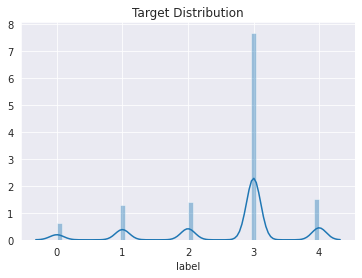

In [12]:
sns.distplot(df['label'])
plt.title('Target Distribution')

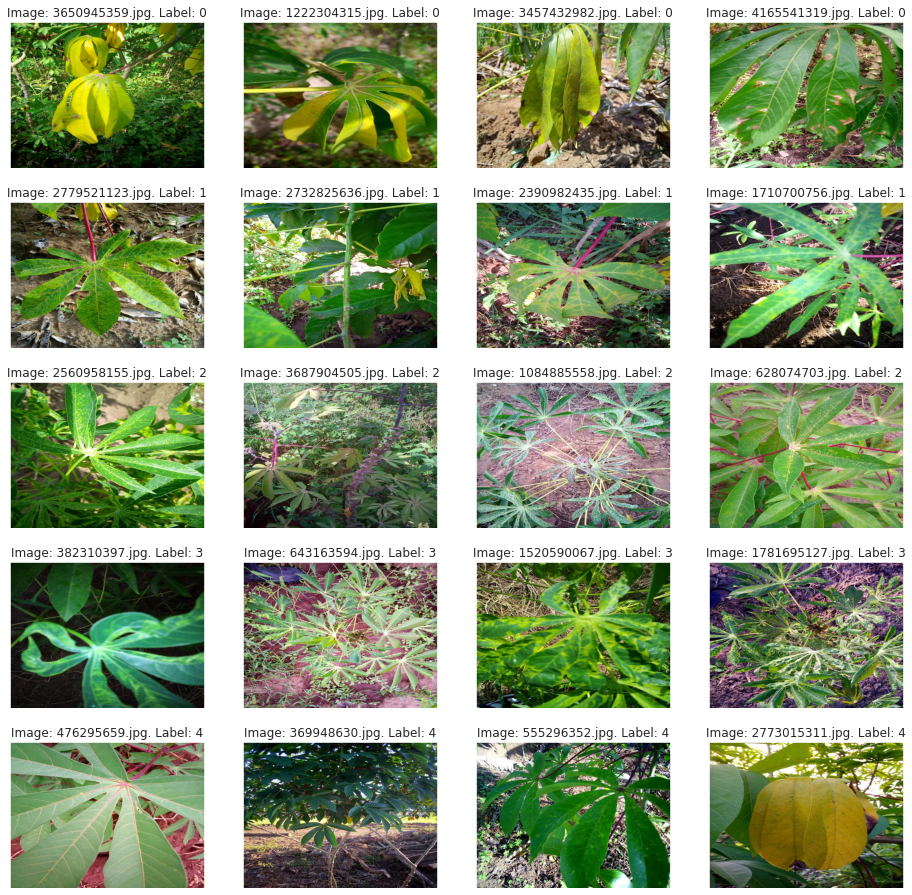

In [13]:
# Showing leaves of each category (label)
selected_images = []
fig = plt.figure(figsize=(16, 16))
for class_id, class_name in name_mapping.items():
    for i, (idx, row) in enumerate(df.loc[df['label'] == class_id].sample(4).iterrows()):
        ax = fig.add_subplot(5, 4, class_id * 4 + i + 1, xticks=[], yticks=[])
        img = cv2.imread(f"{path}train_images/{row['image_id']}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        ax.set_title(f"Image: {row['image_id']}. Label: {row['label']}")
        if i == 0:
            selected_images.append(img)

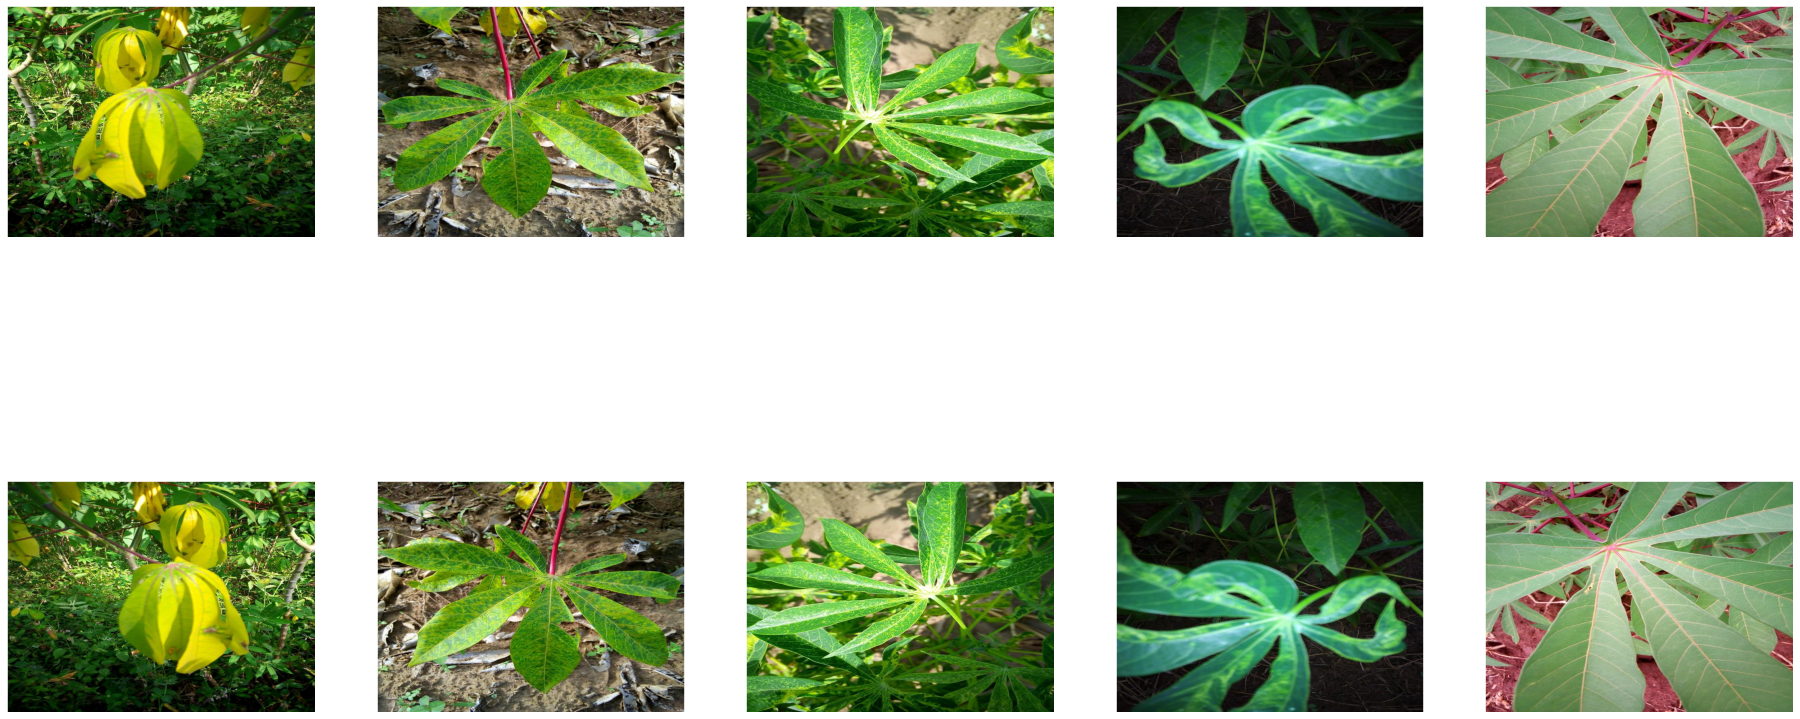

In [14]:
visualize(selected_images, A.HorizontalFlip(p=1))

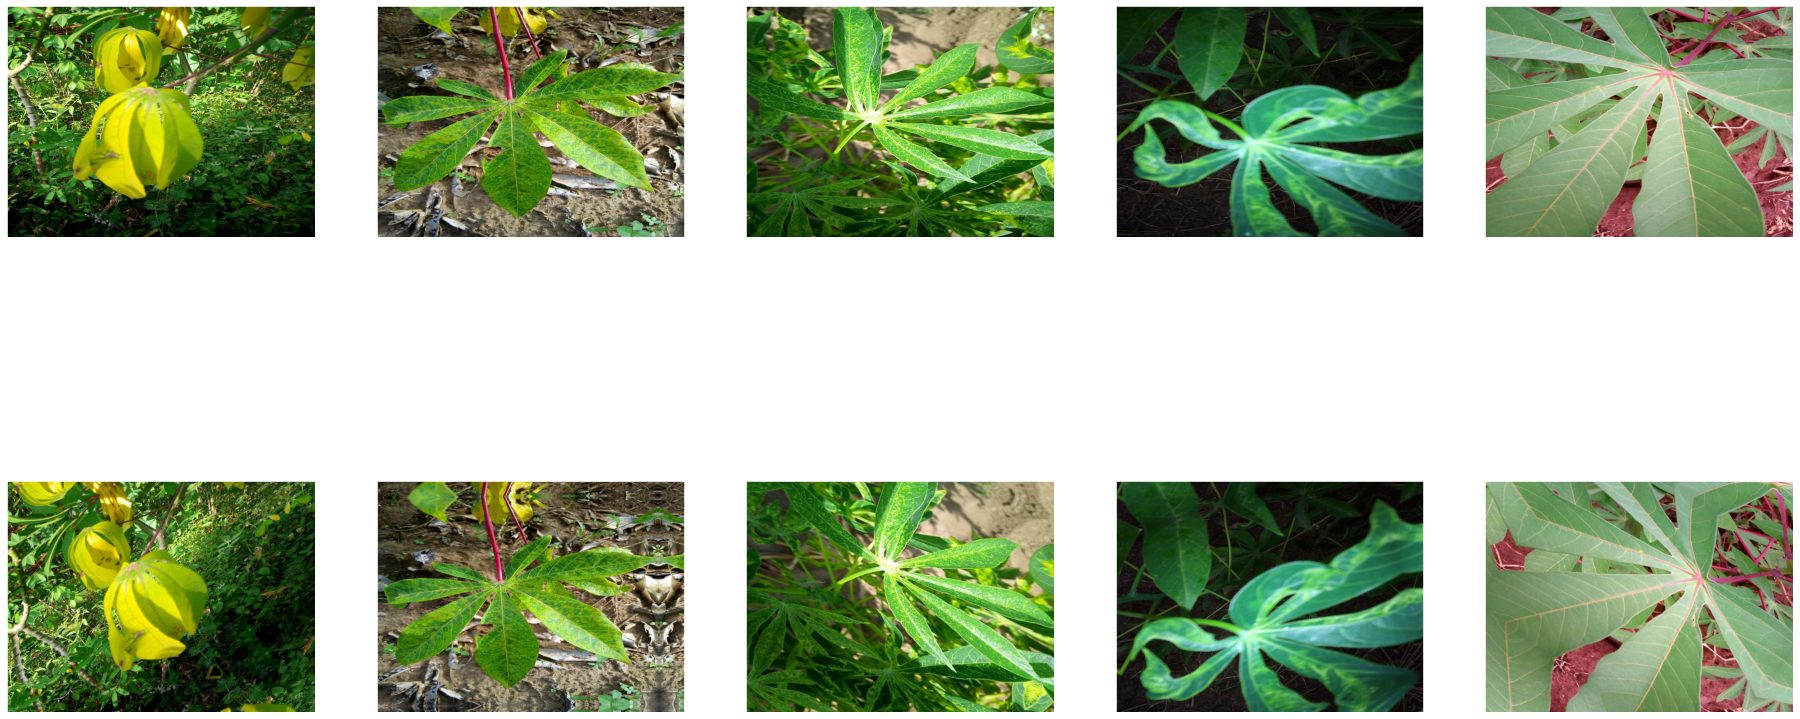

In [15]:
visualize(selected_images, A.ShiftScaleRotate(p=1))

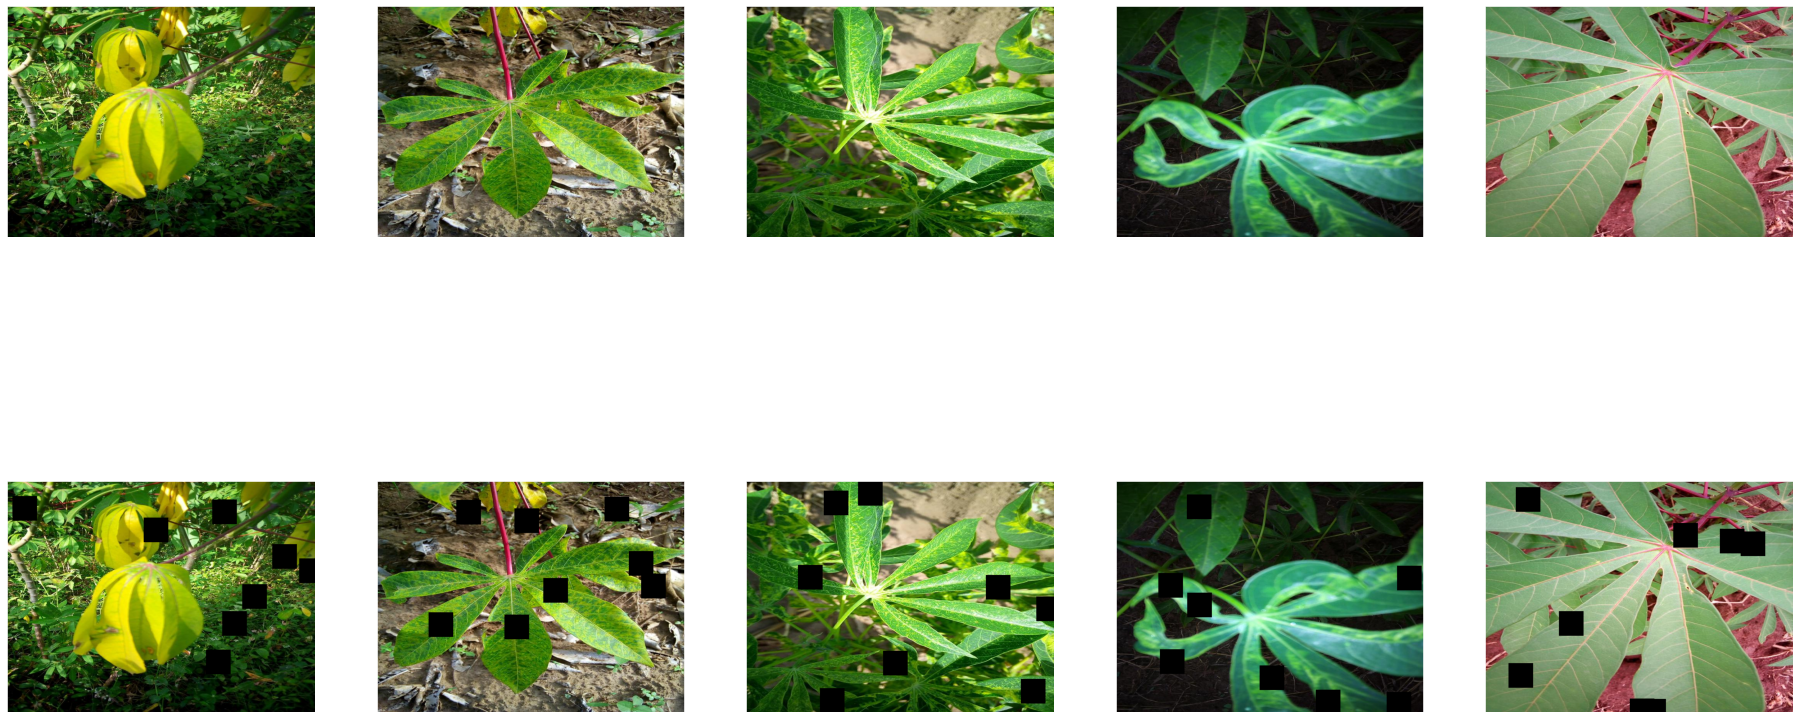

In [16]:
visualize(selected_images, A.Cutout(max_h_size=64, max_w_size=64, p=1))

### Stratified K-Fold Cross Validation

In [17]:
if __name__ == "__main__":
    df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
    df["kfold"] = -1
    df = df.sample(frac=1).reset_index(drop=True)
    y = df.label.values
    kf = model_selection.StratifiedKFold(n_splits=5)
    for f,(t_,v_) in enumerate(kf.split(X=df, y=y)):
        df.loc[v_, 'kfold'] = f
    
    df.to_csv("train_folds.csv", index=False)

In [18]:
df_train = pd.read_csv("./train_folds.csv")

In [19]:
df_train

image_id  label  kfold
0      1082887568.jpg      2      0
1       255823836.jpg      1      0
2       427529521.jpg      3      0
3      1556792485.jpg      3      0
4      2501436016.jpg      3      0
...               ...    ...    ...
21392  1417876180.jpg      3      4
21393  2618313082.jpg      1      4
21394  1410447291.jpg      3      4
21395  2903569390.jpg      3      4
21396  4106981326.jpg      3      4

[21397 rows x 3 columns]

In [20]:
df_train.shape

(21397, 3)

## Create train and validation datasets

In [21]:
training_image_path = "../input/cassava-leaf-disease-classification/train_images/"
dfx_train = df_train.reset_index(drop=True)
dfx_valid = df_train.reset_index(drop=True)

# list of image paths for training
train_images = [os.path.join(training_image_path, i) for i in dfx_train.image_id.values]

# list of image paths for validation
valid_images = [os.path.join(training_image_path, i) for i in dfx_valid.image_id.values]

# targets for training
train_targets = dfx_train.label.values

# targets for validation
valid_targets = dfx_valid.label.values

In [22]:
# class imDataset: dataset of images
class imDataset:
    def __init__(
        self,
        image_paths,
        targets,
        resize,
        augmentations=None,
        backend="pil",
        channel_first=True,
    ):
        """
        :param image_paths: list of paths to images
        :param targets: numpy array
        :param resize: tuple or None
        :param augmentations: albumentations augmentations
        """
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations
        self.backend = backend
        self.channel_first = channel_first
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        targets = self.targets[item]
        if self.backend == "pil":
            image = Image.open(self.image_paths[item])
            if self.resize is not None:
                image = image.resize(
                    (self.resize[1], self.resize[0]), resample=Image.BILINEAR
                )
            image = np.array(image)
            if self.augmentations is not None:
                augmented = self.augmentations(image=image)
                image = augmented["image"]
        elif self.backend == "cv2":
            image = cv2.imread(self.image_paths[item])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.resize is not None:
                image = cv2.resize(
                    image,
                    (self.resize[1], self.resize[0]),
                    interpolation=cv2.INTER_CUBIC,
                )
            if self.augmentations is not None:
                augmented = self.augmentations(image=image)
                image = augmented["image"]
        else:
            raise Exception("Backend not implemented")
        if self.channel_first:
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            "image": torch.tensor(image),
            "targets": torch.tensor(targets),
        }

In [23]:
# create training dataset
training_dataset = imDataset(
    image_paths = train_images,
    targets = train_targets,
    resize=(256, 256),
    augmentations=None,
)

# create validation dataset
validation_dataset = imDataset(
    image_paths = valid_images,
    targets = valid_targets,
    resize=(256, 256),
    augmentations=None,
)

In [29]:
training_dataset[0]

{'image': tensor([[[122., 126., 123.,  ..., 142., 160., 161.],
          [124., 120., 118.,  ..., 134., 161., 167.],
          [120., 115., 118.,  ..., 125., 150., 149.],
          ...,
          [ 51.,  35.,  32.,  ...,  79.,  71.,  66.],
          [ 33.,  28.,  30.,  ...,  80.,  70.,  66.],
          [ 28.,  27.,  28.,  ...,  77.,  69.,  66.]],
 
         [[145., 149., 145.,  ..., 131., 145., 146.],
          [149., 144., 143.,  ..., 125., 149., 156.],
          [147., 143., 146.,  ..., 121., 145., 145.],
          ...,
          [ 52.,  34.,  28.,  ...,  96.,  88.,  83.],
          [ 32.,  27.,  26.,  ...,  97.,  87.,  83.],
          [ 25.,  24.,  25.,  ...,  94.,  86.,  83.]],
 
         [[129., 133., 128.,  ..., 114., 128., 129.],
          [134., 130., 127.,  ..., 108., 132., 138.],
          [132., 128., 131.,  ..., 103., 125., 124.],
          ...,
          [ 34.,  17.,  11.,  ...,  86.,  78.,  73.],
          [ 14.,   9.,   9.,  ...,  87.,  77.,  73.],
          [  6.,   6.,

In [25]:
validation_dataset[0]

{'image': tensor([[[122., 126., 123.,  ..., 142., 160., 161.],
          [124., 120., 118.,  ..., 134., 161., 167.],
          [120., 115., 118.,  ..., 125., 150., 149.],
          ...,
          [ 51.,  35.,  32.,  ...,  79.,  71.,  66.],
          [ 33.,  28.,  30.,  ...,  80.,  70.,  66.],
          [ 28.,  27.,  28.,  ...,  77.,  69.,  66.]],
 
         [[145., 149., 145.,  ..., 131., 145., 146.],
          [149., 144., 143.,  ..., 125., 149., 156.],
          [147., 143., 146.,  ..., 121., 145., 145.],
          ...,
          [ 52.,  34.,  28.,  ...,  96.,  88.,  83.],
          [ 32.,  27.,  26.,  ...,  97.,  87.,  83.],
          [ 25.,  24.,  25.,  ...,  94.,  86.,  83.]],
 
         [[129., 133., 128.,  ..., 114., 128., 129.],
          [134., 130., 127.,  ..., 108., 132., 138.],
          [132., 128., 131.,  ..., 103., 125., 124.],
          ...,
          [ 34.,  17.,  11.,  ...,  86.,  78.,  73.],
          [ 14.,   9.,   9.,  ...,  87.,  77.,  73.],
          [  6.,   6.,

In [30]:
def plot_image(img_dict):
    image_tensor = img_dict["image"]
    target = img_dict["targets"]
    print(target)
    plt.figure(figsize=(10, 10))
    image = image_tensor.permute(1, 2, 0) / 255
    plt.imshow(image)

tensor(2)


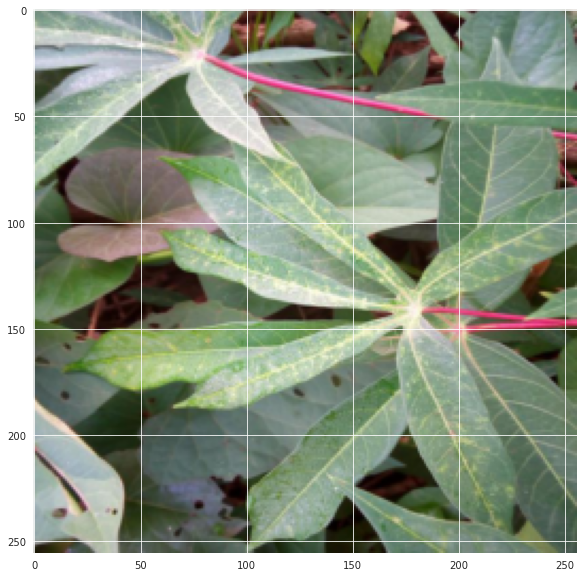

In [31]:
plot_image(training_dataset[0])

In [36]:
# Augmentations

train_aug = albumentations.Compose(
    [
        albumentations.RandomResizedCrop(256, 256),
        albumentations.Transpose(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.ShiftScaleRotate(p=0.5),
        ])

# set augmentations to training_dataset
training_dataset = imDataset(
    image_paths = train_images,
    targets = train_targets,
    resize = None,
    augmentations = train_aug
)

tensor(2)


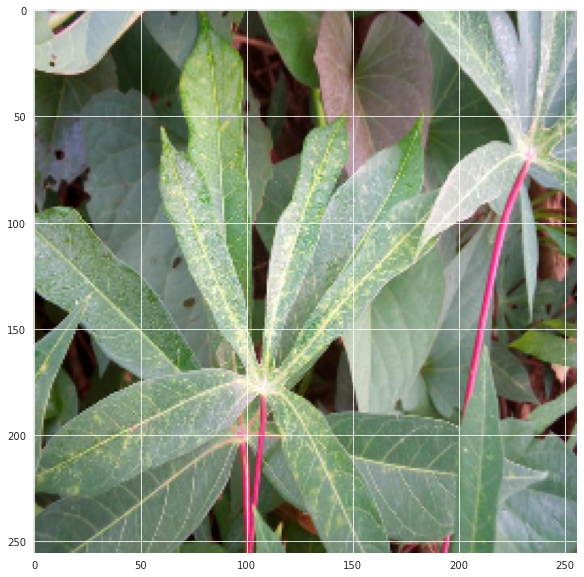

In [38]:
plot_image(training_dataset[0])

## Model Creation

In [40]:
!pip install timm

     |████████████████████████████████| 244 kB 882 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [41]:
import timm

In [48]:
class CassavaClassifier(nn.Module):
    def __init__(self, num_classes, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [49]:
model = CassavaClassifier(num_classes = 5, model_name = 'resnext50_32x4d')

NameError: name 'CassavaClassifier' is not defined